In [2]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')


# Práctica 1

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import string, random
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import gzip
import pickle
import itertools

import queue as qe

from sklearn.linear_model import LinearRegression

import networkx as nx

In [55]:
def fit_plot(l, func_2_fit, size_ini, size_fin, step):
    l_func_values =[i*func_2_fit(i) for i in range(size_ini, size_fin+1, step)]
    
    lr_m = LinearRegression()
    X = np.array(l_func_values).reshape( len(l_func_values), -1 )
    lr_m.fit(X, l)
    y_pred = lr_m.predict(X)
    
    plt.plot(l, '*', y_pred, '-')

def n2_log_n(n):
    return n**2. * np.log(n)

En esta parte vamos a trabajar con grafos ponderados usando dos EdD:

- Una matriz numpy de adyacencia, donde el elemento i, j indica el peso c_{ij`
  de la rama (i, j)
- Un diccionario de diccionarios de diccionarios donde las claves del primer diccionario G son índices de nodos, las claves de los diccionarios G[i] son los vértices de su lista de adyacencia y un diccionario G[i][j] contiene el peso de la rama (i, j).

Por ejemplo, para el grafo:

el código

l = [[0, 10, 1, np.inf],
[np.inf, 0, 1, np.inf],
[np.inf, np.inf, 0, 1 ],
[np.inf, 1, np.inf, 0]]

m_g = np.array(l)

generaría su matriz de adyacencia según se describe arriba, mientras que

d_g = {
0: {1: 10, 2:1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

generaría su descripción como un dict.

In [6]:
l = [
[0, 10, 1, np.inf],
[np.inf, 0, 1, np.inf],
[np.inf, np.inf, 0, 1 ],
[np.inf, 1, np.inf, 0]
]

m_g = np.array(l)

def print_m_g(m_g):
    print("graph_from_matrix:\n")
    n_v = m_g.shape[0]
    for u in range(n_v):
        for v in range(n_v):
            if v != u and m_g[u, v] != np.inf:
                print("(", u, v, ")", m_g[u, v])

d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

def print_d_g(d_g):
    print("\ngraph_from_dict:\n")
    for u in d_g.keys():
        for v in d_g[u].keys():
            print("(", u, v, ")", d_g[u][v])

print_m_g(m_g)
print_d_g(d_g)

graph_from_matrix:

( 0 1 ) 10.0
( 0 2 ) 1.0
( 1 2 ) 1.0
( 2 3 ) 1.0
( 3 1 ) 1.0

graph_from_dict:

( 0 1 ) 10
( 0 2 ) 1
( 1 2 ) 1
( 2 3 ) 1
( 3 1 ) 1


In [7]:
def rand_matr_pos_graph(n_nodes, sparse_factor, max_weight=50., decimals=0):
    """
    Método que genera grafos de manera aleatoria

    :param n_nodes: Número de nodos que tendrá el grafo
    :param sparse_factor: Proporción de ramas (probabilidad de que una ramas inexistentes)
    :param max_weight: Peso máximo que podría tener una rama
    :param decimals: Número de decimales
    :return: grafo generado
    """
    grafo_completo = np.around(max_weight * np.random.rand(n_nodes, n_nodes),decimals)
    ramas = np.random.binomial(1, sparse_factor, size=(n_nodes, n_nodes)).astype(np.float32)  # dicta si hay ramas o no

    for u in range(n_nodes):
        for v in range(n_nodes):
            if ramas[u][v] == 1:
                grafo_completo[u][v] = np.inf

    np.fill_diagonal(grafo_completo, 0)

    return grafo_completo

def m_g_2_d_g(m_g):
    """
    Método que pasa un grafo en formato de matriz a uno en formato de diccionario

    :param m_g: Grafo en formato de matriz
    :return: Grafo en formato de diccionario
    """
    d_g = {}

    n_v = m_g.shape[0]
    for i in range(n_v):
        for j in range(n_v):
            if d_g.get(i) == None:
                d_g.update({i:{}})
            if i != j and m_g[i][j] != np.inf:
                d_g[i].update({j:m_g[i][j]})

    return d_g


def d_g_2_m_g(d_g):
    """
    Método que pasa un diccionario en formato de diccionario a uno en formato de matriz

    :param d_g: Grafo en formato de diccionario
    :return: Grafo en formato de matriz
    """
    nkeys = len(d_g.keys())

    m_g = np.empty((nkeys, nkeys), np.float32)

    for i in range(nkeys):
        for j in range(nkeys):
            if d_g[i].get(j) != None and i != j:
                m_g[i][j] = d_g[i].get(j)
            elif i != j:
                m_g[i][j] = np.inf
            else:
                m_g[i][j] = 0

    return m_g


################################################# cheking
m_g = rand_matr_pos_graph(n_nodes=5,sparse_factor=0.5,max_weight=50.)
d_g = m_g_2_d_g(m_g)
m_g_2 = d_g_2_m_g(d_g)

print_m_g(m_g)
print_d_g(d_g)
print("\num_elem_iguales:\t%d" % (m_g_2 == m_g).sum() )

graph_from_matrix:

( 0 2 ) 17.0
( 0 3 ) 41.0
( 0 4 ) 29.0
( 1 4 ) 7.0
( 2 0 ) 16.0
( 2 1 ) 46.0
( 2 3 ) 21.0
( 3 2 ) 21.0
( 3 4 ) 22.0

graph_from_dict:

( 0 2 ) 17.0
( 0 3 ) 41.0
( 0 4 ) 29.0
( 1 4 ) 7.0
( 2 0 ) 16.0
( 2 1 ) 46.0
( 2 3 ) 21.0
( 3 2 ) 21.0
( 3 4 ) 22.0

um_elem_iguales:	25


In [8]:
def cuenta_ramas(m_g):
    """
    Método que cuenta las ramas que hay en el grafo

    :param m_g: Grafo
    :return: Número de ramas que tiene el grafo
    """
    return len(np.flatnonzero(np.where(m_g == np.inf,0,1))) - m_g.shape[0]


def check_sparse_factor(n_grafos,n_nodes, sparse_factor):
    """
    Método que calcula la proporción de ramas según una serie de grafos

    :param n_grafos: Número de grafos
    :param n_nodes: Número de nodos de cada grafo
    :param sparse_factor: Proporción de ramas
    :return: La proporción de ramas que hay en los grafos
    """
    grafos = [None]*n_grafos
    ramas = [None]*n_grafos
    factores = [None]*n_grafos

    for i in range(n_grafos):
        grafos[i] = rand_matr_pos_graph(n_nodes,sparse_factor,10.,decimals=2)
        ramas[i] = cuenta_ramas(grafos[i])
        factores[i] = ramas[i] / (n_nodes**2 - n_nodes)

    return 1 - np.average(factores)

############################################################ checking
print(cuenta_ramas(m_g))

n_grafos=50
n_nodes=20
sparse_factor = 0.75

print("\ntrue_sparse_factor: %.3f" % sparse_factor, 
      "\nexp_sparse_factor:  %.3f" % check_sparse_factor(n_grafos=n_grafos, n_nodes=n_nodes, sparse_factor=sparse_factor))

9

true_sparse_factor: 0.750 
exp_sparse_factor:  0.752


# 2 Guardando y leyendo grafos
## 2.1 Guardando y leyendo grafos con pickle

In [9]:
def save_object(obj, f_name="obj.pklz", save_path='.'):
    """
    Método que guardará un objeto (En este caso un grafo) en un fichero dado
    
    :param obj: Objeto a guardar
    :param f_name: Nombre del fichero
    :param save_path: Ruta en donde se guardará el fichero
    :return: No devuelve nada
    """
    file_path = save_path + f_name

    final_file = gzip.open(file_path, 'wb')

    pickle.dump(obj, final_file)

    final_file.close()



def read_object(f_name, save_path='.'):
    """
    Método que lee un objeto de un fichero
    
    :param f_name: Nombre del fichero
    :param save_path: Ruta del fichero
    :return: Objeto guardado
    """
    file_path = save_path + f_name

    final_file = gzip.open(file_path, 'rb')

    data = pickle.load(final_file)

    final_file.close()

    return data


## Cuestiones sobre guardado de grafos
### Cuestión 1
**Describir qué se entiende por serializar un objeto Python.**

A través de un protocolo binario, transformar el objeto Python y guardarlo en un archivo que se guarda en memoria.

### Cuestión 2
**Json es otro formato de serialiación de objetos. Comentar brevemente posibles diferencias entre pickle y json.**

- _**Interoprabilidad:**_
Pickle es un módulo que sólo se puede usar en Python, es decir, los objetos serializados por pickle **no pueden** ser accedidos por programas escritos por otros lenguaje.
Sin embargo, Json es un estándar de serialización al que tienen acceso **todos** los lenguajes de programación, permitiendo que la información almacenada sea accesible y colaborativa.


- _**Velocidad:**_
Por cómo está implementado Pickle, es un módulo lento que para grandes cantidades de datos puede llegar a ser **muy costoso e ineficiente** (dato para ponerlo en escala: el módulo Pickle está disponible desde la versión 1.4 de Python, y en la versión 1.5 empezó a estar disponible el módulo cPickle, implementado en c y hasta 1000 veces más rápido.). 
Json en comparación es mucho más rápido.


- _**Seguridad:**_
Pickle puede ejecutar código aleatorio almacenado en memoria. Por lo tanto, usar **pickle** para transferir datos entre diferentes programas o sesiones puede llegar a ser una importante brecha de seguridad.
Por otro lado Json tiene mecanismos de seguridad integrados, según su RFC 8259, que impiden el acceso a memoria aleatoria, controlando las posibles brechas de seguridad.


- _**Lectura del fichero en bruto:**_
Json te permite abrir el archivo **en cualquier momento** y revisar su contenido, reforzando los aspectos de interoperabilidad y seguridad. Sin embargo, el contenido de los archivos de información creados con pickle son una cadena binaria que a primera vista podría suponer una amenaza, hasta que se demuestre lo contrario.


- _**Información guardada:**_
Pickle guarda toda la información del objeto, lo cual puede dar cabida a datos del objeto que no sean necesarios, mientras que Json guarda únicamente la información que necesitamos.

## 2.2 The Trivial Graph Format

In [10]:
def d_g_2_TGF(d_g, f_name):
    """
    Método que se encarga de pasar de un grafo en formato de diccionario a uno en formato TGF y de guardarlo en un fichero
    
    :param d_g: Grafo
    :param f_name: Nombre del fichero donde se guardará el grafo
    :return: No devuelve nada
    """
    
    fp = open(f_name, 'w')
    
    nNodos = len(d_g.keys())

    data = ''

    for key, value in d_g.items():
        data = data + str(key) + '\n'

    data = data + '#\n'

    for key, value in d_g.items():
        nkeys = len(value.keys())
        for key2, value2 in value.items():
            data = data + str(key) + ' ' + str(key2) + ' ' + str(value2) + '\n'
        

    fp.write(data)
    
    fp.close()
    

def TGF_2_d_g(f_name):
    """   
    Método que se encarga de leer un grafo en formato TGF de un fichero y pasarlo a formato de diccionario
    
    :param f_name: Nombre del fichero
    :return: Grafo en formato de diccionario
    """
    
    fp = open(f_name, 'r')
    
    d_g = {}

    
    data = fp.read()
    
    data = data.split('\n')
    aux  = []
    
    for i in data:
        aux.append(i)
        if i != '#':
            d_g.update({i:{}})
            
        else:
            break
        
    data = data[len(aux):-1]
    
    for i in data:
        s = i.split(' ')
        d_g[s[0]].update({s[1]:s[2]})
    
    return d_g
    
############################################################ checking
f_name = "gr.tgf"
d_g_2_TGF(d_g, f_name)
                       
d_g_2 = TGF_2_d_g(f_name)            
print_d_g(d_g)
print_d_g(d_g_2)


graph_from_dict:

( 0 2 ) 17.0
( 0 3 ) 41.0
( 0 4 ) 29.0
( 1 4 ) 7.0
( 2 0 ) 16.0
( 2 1 ) 46.0
( 2 3 ) 21.0
( 3 2 ) 21.0
( 3 4 ) 22.0

graph_from_dict:

( 0 2 ) 17.0
( 0 3 ) 41.0
( 0 4 ) 29.0
( 1 4 ) 7.0
( 2 0 ) 16.0
( 2 1 ) 46.0
( 2 3 ) 21.0
( 3 2 ) 21.0
( 3 4 ) 22.0


### Cuestión 3
**¿Qué ventajas e inconvenientes tendrían las funciones pickle sobre las construidas mediante el formato TFG? Responder algo pertinente y no con lugares comunes.**

Un inconveniente que tiene TGF es que es muy tedioso leer la información deseada de un fichero con este formato. Tenemos que usar múltiples listas, partiendo las strings del fichero constantemente hasta que encontramos la información desada y podemos formar el grafo. Pickle guarda y lee el objeto en una sóla función por acción. Sin embargo, como antes hemos mencionado, pickle almacena mucha información innecesaria del objeto.

# 3 Distancias Mínimas en Grafos
## 3.1 Programming and Timing Dijstra

In [11]:
def dijkstra_d(d_g, u):
    """
    Método que aplica el algoritmo de Dijkstra a un grafo en formato de diccionario a partir de un nodo inicial dado
    
    :param d_g: Grafo en formato de diccionario
    :param u: Nodo inicial
    :return: un diccionario con las distancias mínimas al resto de nodos, y un diccionario con los nodos precios
    """
    d_dist = {}
    d_prev = {}
    distancias = np.full(len(d_g.keys()), np.inf)    
    vistos = np.full(len(d_g.keys()), False)
    padre = np.full(len(d_g.keys()), None)
    
    q = qe.PriorityQueue()
    distancias[u] = 0.
    q.put((0.0,u))
    
    while not q.empty():
        n = q.get()
        vistos[n[1]] = True
        
        for keys,values in d_g[n[1]].items():
            if distancias[keys] > distancias[n[1]] + values:
                distancias[keys] = distancias[n[1]] + values
                padre[keys] = n[1]
                q.put((distancias[keys], keys))
    
    for i in range(len(distancias)):
        d_dist.update({i:distancias[i]})
        d_prev.update({i:padre[i]})
    
    return d_dist,d_prev

def dijkstra_m(m_g,u):
    """
    Método que aplica el algoritmo de Dijkstra a un grafo en formato de matriz a partir de un nodo inicial dado
    
    :param m_g: Grafo en formato de matriz
    :param u: Nodo inicial
    :return: un diccionario con las distancias mínimas al resto de nodos, y un diccionario con los nodos previos
    """
    d_dist = {}
    d_prev = {}
    n_v = m_g.shape[0]
    distancias = np.full(n_v, np.inf)    
    vistos = np.full(n_v, False)
    padre = np.full(n_v, None)
    
    q = qe.PriorityQueue()
    distancias[u] = 0.
    q.put((0.0,u))
    
    while not q.empty():
        n = q.get()
        vistos[n[1]] = True

        for i in m_g[n[1]]:
            if distancias[m_g[n[1]].tolist().index(i)] > distancias[n[1]] + i:
                distancias[m_g[n[1]].tolist().index(i)] = distancias[n[1]] + i
                padre[m_g[n[1]].tolist().index(i)] = n[1]
                q.put((distancias[m_g[n[1]].tolist().index(i)], m_g[n[1]].tolist().index(i)))


    for i in range(len(distancias)):
        d_dist.update({i:distancias[i]})
        d_prev.update({i:padre[i]})
    
    return d_dist,d_prev

def min_paths(d_prev):
    """
    Método que devuelve los caminos mínimos desde el nodo inicial a cualquier otro nodo.
    
    :param d_prev: Diccionario en el que cada clave contiene su nodo previo
    :return: Un diccionario en el que cada clave contiene la lista de nodos desde el nodo inicial hasta el nodo clave
    """

    d_path = {}
    
    for keys,values in d_prev.items():
        if d_prev[keys] == None:
            d_path.update({keys:[None]})
        else:
            d_path.update({keys:[keys]})
      
    for keys,values in d_prev.items():
        n = keys
        while d_prev[n] != None:
            d_path[keys].append(d_prev[n])
            n = d_prev[n]
            
        d_path.update({keys:list(reversed(d_path[keys]))})
         
    return d_path

def time_dijktra_m(n_graphs,n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Método que mide los tiempos de aplicar Dijkstra a un número de grafos en formato de matriz con varios parámetros dados
    
    :param n_graphs: Número de grafos a generar
    :param n_nodes_ini: Número de nodos inicial
    :param n_nodes_fin: Número de nodos final
    :param step: Incremento en el número de nodos después de cada turno
    :param sparse_factor: Proporción de ramas
    :return: Lista con los tiempos devueltos para cada grafo al que se le aplicó Dijkstra
    """    
    grafos = []
    dijktras = []
    i = 0
    n_nodes_act = n_nodes_ini
    
    while n_nodes_act <= n_nodes_fin:
        grafos.append(rand_matr_pos_graph(n_nodes_act, sparse_factor, max_weight=10., decimals=2))
            
        inicio = time.time()
        dijkstra_m(grafos[i],0)
        fin = time.time()
        
        dijktras.append(fin-inicio)
        
        i += 1
        n_nodes_act += step
    
    return dijktras

def time_dijkstra_d(n_graphs,n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Método que mide los tiempos de aplicar Dijkstra a un número de grafos en formato de diccionario con varios parámetros dados
    
    :param n_graphs: Número de grafos a generar
    :param n_nodes_ini: Número de nodos inicial
    :param n_nodes_fin: Número de nodos final
    :param step: Incremento en el número de nodos después de cada turno
    :param sparse_factor: Proporción de ramas
    :return: Lista con los tiempos devueltos para cada grafo al que se le aplicó Dijkstra
    """
    grafos = []
    dijktras = []
    i = 0
    n_nodes_act = n_nodes_ini
    
    while n_nodes_act <= n_nodes_fin:
        grafos.append(m_g_2_d_g(rand_matr_pos_graph(n_nodes_act, sparse_factor, max_weight=10., decimals=2)))
            
        inicio = time.time()
        dijkstra_d(grafos[i],0)
        fin = time.time()
        
        dijktras.append(fin-inicio)
        
        i += 1
        n_nodes_act += step
    
    return dijktras

############################################################ checking

d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}
"""
d_g = {
0: {2:3},
1: {0:2},
2: {},
3: {1:1},
4: {0,2},
}
"""
u_ini = 3

d_dist, d_prev = dijkstra_d(d_g, u_ini)
print(d_dist, '\n', min_paths(d_prev))

d_g_nx = nx.DiGraph()
l_e = [(0, 1, 10), (0, 2, 1), (1, 2, 1), (2, 3, 1), (3, 1, 1)]
d_g_nx.add_weighted_edges_from(l_e)

d, p = nx.single_source_dijkstra(d_g_nx, u_ini, weight='weight')    
print(d, '\n', p)

{0: inf, 1: 1.0, 2: 2.0, 3: 0.0} 
 {0: [None], 1: [3, 1], 2: [3, 1, 2], 3: [None]}
{3: 0, 1: 1, 2: 2} 
 {3: [3], 1: [3, 1], 2: [3, 1, 2]}


## Cuestiones sobre Dijkstra
### Cuestión 1

**¿Cuál es el coste teórico del algoritmo de Dijkstra? Justificar brevemente dicho coste **

Para un grafo de V vértices y E ramas, el coste de Dijkstra es O(|E|*Log|V|). Este coste se puede ver alterado según la estructura de datos que utilicemos para desarrollar el algoritmo. Esta fórmula sale de las operaciones básicas del algoritmo: insertar y obtener en la estructura de datos es una operación de coste logarítmico, y dado que se va a hacer para cada uno de las ramas se añade la E. V no se reflejada dado que en comparación al número de ramas, el número de nodos no influye.

### Cuestión 2

**Expresar el coste de Dijkstra en función del número de nodos y el sparse factor  $\varphi$ del grafo en cuestión. Para un número de nodos fijo adecuado, ¿cuál es el crecimiento del coste de Dijkstra en función de $\varphi$? **

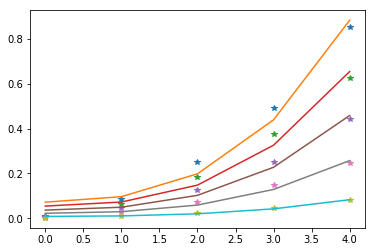

In [62]:
n_graphs=5
n_nodes_ini=100
n_nodes_fin=1000
step=200

sparse_f1= 0.1
sparse_f3= 0.3
sparse_f5= 0.5
sparse_f7= 0.7
sparse_f9= 0.9

l_t_d1 = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f1)
l_t_d3 = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f3)
l_t_d5 = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f5)
l_t_d7 = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f7)
l_t_d9 = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f9)

#l_t_final = l_t_d1+l_t_d3+l_t_d5+l_t_d7+l_t_d9
#print(l_t_final)

fit_plot(l_t_d1, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d3, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d5, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d7, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d9, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)

La gráfica que se puede observar representa el algoritmo de Dijkstra cinco veces cambiando el sparse factor, y podemos observar que entre más grande sea el sparse factor, menos ramas tendrá el grafo y por lo tanto, menos tiempo tardará Dijkstra en realizarse (la línea que está más arriba representa el grafo de menor sparse factor, y llega a ser hasta casi 10 veces más lento que el grafo que tiene mayor sparse factor).

Creemos que el crecimiento del coste de Dijkstra en función del sparse factor es logarítmico, como se puede ver en la gráfica.

### Cuestión 3

**¿Cuál es el coste teórico del algoritmo de Dijkstra iterado para encontrar las distancias mínimas entre todos los vértices de un grafo?**

El coste de Dijkstra iterado es: O(|E|*Log|V|) * el número de vértices (V), lo cual es igual a O(|V|*|E|*Log|V|). Y si el grafo es denso, el coste es O(|V|³*Log|V|)

### Cuestión 4

**¿Cómo se podrían recuperar los caminos mínimos si se utiliza Dijkstra iterado?**

Asumimos que un método 'dijkstra_d_iter' devuelve un diccionario 'd_prev_iter' con un nivel más de diccionario, es decir, cada clave de 'd_prev_iter' contiene un diccionario 'd_prev' resultado de aplicar Dijkstra con la clave como nodo inicial. 

Tendríamos que implementar un método 'min_path_iter(d_prev_iter)' que hace para cada una de las claves de 'd_prev_iter' el 'min_path' ya implementado, dejando como resultado un diccionario con un nivel más a los devueltos por 'min_path'.


## 3.2 Plotting Dijkstra's Execution Times
Fit below a linear model An^2 logn+B to the times in the returned lists and plot the real and fitted times discussing the results.

In [41]:
n_graphs=20
n_nodes_ini=10
n_nodes_fin=100
step=5
sparse_f= 0.25
l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

[[  2.30258509e+03]
 [  9.13966943e+03]
 [  2.39658582e+04]
 [  5.02949348e+04]
 [  9.18323293e+04]
 [  1.52435548e+05]
 [  2.36088285e+05]
 [  3.46882119e+05]
 [  4.89002876e+05]
 [  6.66720059e+05]
 [  8.84378425e+05]
 [  1.14639110e+06]
 [  1.45723387e+06]
 [  1.82144030e+06]
 [  2.24359764e+06]
 [  2.72834320e+06]
 [  3.28036125e+06]
 [  3.90438020e+06]
 [  4.60517019e+06]]


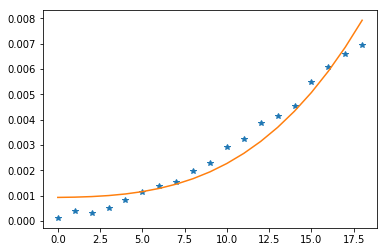

In [42]:
fit_plot(l_t_d, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)

# 4 The networkx Library
We are going to use the networkx library to check our Dijkstra results and to get alternative times.

An example of loading a networkx directed graph is to use a list (i, j, w) of (i, j) edges with weights w can be seen in the following cell:

In [14]:
g = nx.DiGraph()

l_e = [(0, 1, 10), (0, 2, 1), (1, 2, 1), (2, 3, 1), (3, 1, 1)]
g.add_weighted_edges_from(l_e)

for k1 in g.nodes():
    for k2 in g[k1].keys():
        print('(', k1, k2, ')', g[k1][k2]['weight'])

( 0 1 ) 10
( 0 2 ) 1
( 1 2 ) 1
( 2 3 ) 1
( 3 1 ) 1


In [15]:
def d_g_2_nx_g(d_g):
    """
    Método que pasa de un diccionario en formato de diccionario a uno en formato de Networkx
    
    :param d_g: Grafo en formato de diccionario
    :return: Grafo en formato de Networkx
    """
    l_e = []
    g = nx.DiGraph()
    
    for keys,values in d_g.items():
        for keys2,values2 in values.items():
            l_e.append((keys,keys2,values2))

    g.add_weighted_edges_from(l_e)
    return g
    
def nx_g_2_d_g(nx_g):
    """
    Método que pasa de un diccionario en formato de Networkx a uno en formato de diccionario
    
    :param nx_g: Grafo en formato de Networkx
    :return: Grafo en formato de diccionario
    """
    d_g = {}
    
    for i in nx_g.nodes():
        for keys,values in nx_g[i].items():
            if d_g.get(i) == None: 
                d_g.update({i:{}})
            for keys2,values2 in values.items():
                d_g[i].update({keys:values2})
                
    return d_g

def time_dijkstra_nx(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    """
    Método que mide los tiempos de aplicar Dijkstra con la libreria NetworkX a un número de grafos en formato de
        NetworkX en base a varios parámetros dados
    
    :param n_graphs: Número de grafos a generar
    :param n_nodes_ini: Número de nodos inicial
    :param n_nodes_fin: Número de nodos final
    :param step: Incremento en el número de nodos después de cada turno
    :param sparse_factor: Proporción de ramas
    :return: Lista con los tiempos devueltos para cada grafo al que se le aplicó Dijkstra
    """
    grafos = []
    dijktras = []
    i = 0
    n_nodes_act = n_nodes_ini
    
    while n_nodes_act <= n_nodes_fin:
        grafos.append(d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(n_nodes_act, sparse_factor, max_weight=10., decimals=2))))
            
        inicio = time.time()
        nx.single_source_dijkstra(grafos[i],0)
        fin = time.time()
        
        dijktras.append(fin-inicio)
        
        i += 1
        n_nodes_act += step
    
    return dijktras


############################################################ checking
d_g = {
0: {1: 10, 2: 1}, 
1: {2: 1}, 
2: {3: 1},
3: {1: 1}
}

d_g_nx = d_g_2_nx_g(d_g)

print_d_g(d_g)
(d_g_nx)[0][1]


graph_from_dict:

( 0 1 ) 10
( 0 2 ) 1
( 1 2 ) 1
( 2 3 ) 1
( 3 1 ) 1


{'weight': 10}

In [16]:
n_graphs=20
n_nodes_ini=100 
n_nodes_fin=1000
step=50
sparse_f= 0.25
l_t_nx = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

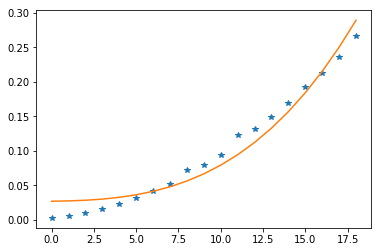

In [17]:
fit_plot(l_t_nx, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)

## Cuestiones sobre Networkx
### Cuestión 1

**Mostrar gráficamente el crecimiento de los tiempos de ejecución del algoritmo de Dijkstra en función del número de nodos y del sparse factor usando la librería Networkx. Usa grafos de 100 nodos y un sparse factor de 0.1, 0.3, 0.5, 0.7, 0.9**

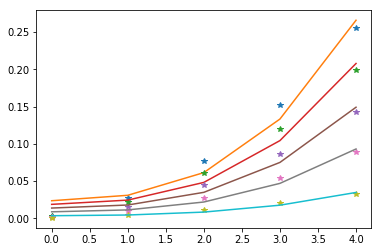

In [64]:
n_graphs=5
n_nodes_ini=100
n_nodes_fin=1000
step=200

sparse_f1= 0.1
sparse_f3= 0.3
sparse_f5= 0.5
sparse_f7= 0.7
sparse_f9= 0.9

l_t_d1 = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f1)
l_t_d3 = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f3)
l_t_d5 = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f5)
l_t_d7 = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f7)
l_t_d9 = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                        n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f9)

#l_t_final = l_t_d1+l_t_d3+l_t_d5+l_t_d7+l_t_d9
#print(l_t_final)

fit_plot(l_t_d1, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d3, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d5, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d7, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)
fit_plot(l_t_d9, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step)

Como podemos observar en esta última gráfica, el algoritmo de Dijkstra con la librería Networkx es mucho más rápido que el nuestro, hasta unas 3 veces más rápido aproximadamente.

### Cuestión 2

**Mide y muestra gráficamente los tiempos de ejecución del algoritmo de Dijkstra iterativo para encontrar las distancias mínimas entre todos los vértices del grafo usando la librería Networkx con grafos de un número fijo de 25 nodos y sparse factors de 0.1, 0.3, 0.5, 0.7, 0.9.**

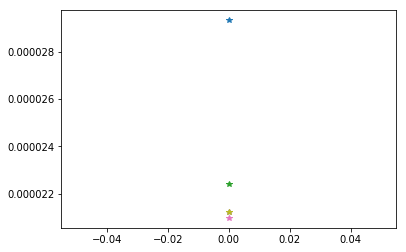

In [74]:
nx1 =  d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(n_nodes=25,sparse_factor=0.1,max_weight=50.)))
nx3 =  d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(n_nodes=25,sparse_factor=0.3,max_weight=50.)))
nx5 =  d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(n_nodes=25,sparse_factor=0.5,max_weight=50.)))
nx7 =  d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(n_nodes=25,sparse_factor=0.7,max_weight=50.)))
nx9 =  d_g_2_nx_g(m_g_2_d_g(rand_matr_pos_graph(n_nodes=25,sparse_factor=0.9,max_weight=50.)))

inicio1 = time.time()
nx.all_pairs_shortest_path(nx1)
fin1 = time.time()

inicio3 = time.time()
nx.all_pairs_shortest_path(nx3)
fin3 = time.time()

inicio5 = time.time()
nx.all_pairs_shortest_path(nx5)
fin5 = time.time()

inicio7 = time.time()
nx.all_pairs_shortest_path(nx7)
fin7 = time.time()

inicio9 = time.time()
nx.all_pairs_shortest_path(nx9)
fin9 = time.time()

t1 = fin1-inicio1
t3 = fin3-inicio3
t5 = fin5-inicio5
t7 = fin7-inicio7
t9 = fin9-inicio9

#l_t_d = [t1,t3,t5,t7,t9]

fit_plot([t1], n2_log_n, size_ini=25, size_fin=25, step=1)
fit_plot([t3], n2_log_n, size_ini=25, size_fin=25, step=1)
fit_plot([t5], n2_log_n, size_ini=25, size_fin=25, step=1)
fit_plot([t7], n2_log_n, size_ini=25, size_fin=25, step=1)
fit_plot([t9], n2_log_n, size_ini=25, size_fin=25, step=1)